In [1]:
%matplotlib inline

import datetime as dt
from collections import OrderedDict
from itertools import islice

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap

HEADER_INDICATOR = '66666'
DATE_FORMAT = '%Y%m%d%H'
LOCATION_PADDING = 20.0
LINE_INTERVAL = 20.0
LATITUDE_OFFSET = 0.0
LONGITUDE_OFFSET = 0.0

typhoons = OrderedDict()
current_typhoon = None

def get_key_by_index(ordered_dict, index):
    return next(islice(ordered_dict, index, index + 1))

def get_value_by_index(ordered_dict, index):
    return ordered_dict[get_key_by_index(ordered_dict, index)]

def get_pair_by_index(ordered_dict, index):
    return next(islice(ordered_dict.items(), index, index + 1))

def format_date(date_string):
    return dt.datetime.strptime(('19' if int(date_string[:2]) <= 99 else '20') + date_string, DATE_FORMAT)

def get_typhoon_by_id(id_number):
    return typhoons[id_number]

def get_typhoon_by_index(index):
    return get_value_by_index(typhoons, index)

typhoon_id_to_plot = int(input('Type the international number ID of a typhoon to plot it.\n> '))

Type the international number ID of a typhoon to plot it.
> 209


In [2]:
with open('bst_all.txt') as data:
    for line in data:
        split_line = line.split()
        split_line_length = len(split_line)
        
        if split_line_length == 0:
            continue
        
        if split_line_length >= 2 and split_line[0] == HEADER_INDICATOR:
            typhoons[int(split_line[1])] = {}
            current_typhoon = get_typhoon_by_index(len(typhoons) - 1)
            
            if split_line[-2][0] in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
                current_typhoon['name'] = split_line[-2].capitalize()
            
            else:
                current_typhoon['name'] = 'Unnamed'
            
            current_typhoon['dates'] = []
            current_typhoon['latitudes'] = []
            current_typhoon['longitudes'] = []
            current_typhoon['pressures'] = []
            current_typhoon['wind_speeds'] = []
            continue

        if current_typhoon:
            if split_line_length >= 1:
                current_typhoon['dates'].append(format_date(split_line[0]))
            
            if split_line_length >= 4:
                current_typhoon['latitudes'].append(float(split_line[3]) / 10)
            
            if split_line_length >= 5:
                current_typhoon['longitudes'].append(float(split_line[4]) / 10)
            
            if split_line_length >= 6:
                current_typhoon['pressures'].append(float(split_line[5]))
            
            if split_line_length >= 7:
                current_typhoon['wind_speeds'].append(float(split_line[6]))

typhoon_to_plot = get_typhoon_by_id(typhoon_id_to_plot)

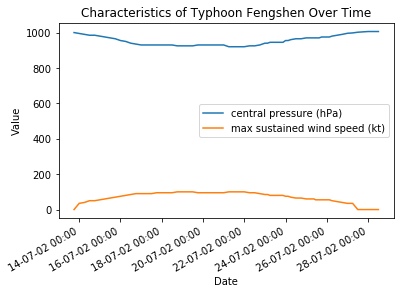

In [3]:
if len(typhoon_to_plot['pressures']) == len(typhoon_to_plot['wind_speeds']) == len(typhoon_to_plot['dates']) >= 1:
    plt.plot(typhoon_to_plot['dates'], typhoon_to_plot['pressures'], label='central pressure (hPa)')
    plt.plot(typhoon_to_plot['dates'], typhoon_to_plot['wind_speeds'], label='max sustained wind speed (kt)')

    plt.legend()
    plt.title('Characteristics of Typhoon ' + typhoon_to_plot['name'] + ' Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.show()

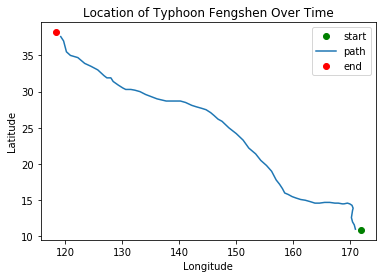

In [4]:
if len(typhoon_to_plot['latitudes']) == len(typhoon_to_plot['longitudes']) >= 1:
    plt.plot(typhoon_to_plot['longitudes'][0], typhoon_to_plot['latitudes'][0], 'go', label='start')
    plt.plot(typhoon_to_plot['longitudes'][1:-1], typhoon_to_plot['latitudes'][1:-1], label='path')
    plt.plot(typhoon_to_plot['longitudes'][-1], typhoon_to_plot['latitudes'][-1], 'ro', label='end')

    plt.legend()
    plt.title('Location of Typhoon ' + typhoon_to_plot['name'] + ' Over Time')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

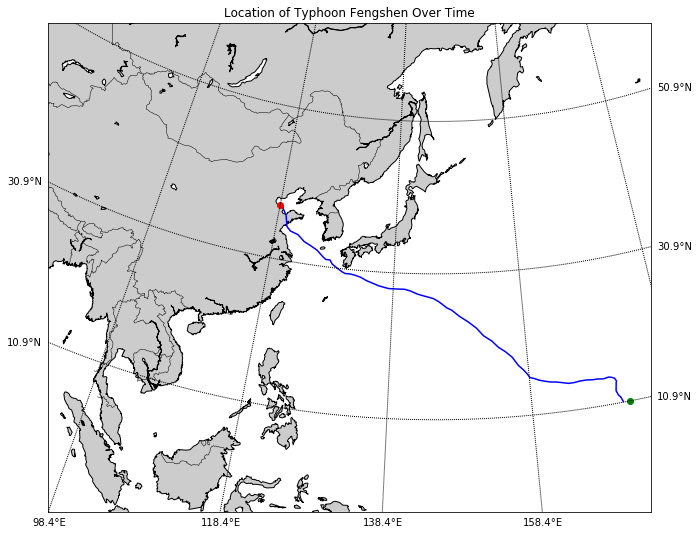

In [5]:
if len(typhoon_to_plot['latitudes']) == len(typhoon_to_plot['longitudes']) >= 1:
    sorted_latitudes = sorted(typhoon_to_plot['latitudes'])
    sorted_longitudes = sorted(typhoon_to_plot['longitudes'])
    (min_latitude, max_latitude) = (sorted_latitudes[0] - LOCATION_PADDING, sorted_latitudes[-1] + LOCATION_PADDING)
    (min_longitude, max_longitude) = (sorted_longitudes[0] - LOCATION_PADDING, sorted_longitudes[-1] + LOCATION_PADDING)
    
    fig = plt.figure(figsize=(15,9))
    axes = fig.add_subplot(1, 1, 1)
    mapping = Basemap(llcrnrlon=min_longitude, llcrnrlat=min_latitude, urcrnrlon=max_longitude, urcrnrlat=max_latitude, projection='lcc', lat_0=(min_latitude+max_latitude)/2.0, lon_0=(min_longitude+max_longitude)/2.0, resolution='l', area_thresh=1000.0)

    mapping.plot(typhoon_to_plot['longitudes'][0], typhoon_to_plot['latitudes'][0], latlon=True, linewidth=1.5, color='g', marker='o')
    mapping.plot(typhoon_to_plot['longitudes'][1:-1], typhoon_to_plot['latitudes'][1:-1], latlon=True, linewidth=1.5, color='b')
    mapping.plot(typhoon_to_plot['longitudes'][-1], typhoon_to_plot['latitudes'][-1], latlon=True, linewidth=1.5, color='r', marker='o')

    mapping.drawcoastlines()
    mapping.drawcountries()
    mapping.fillcontinents()
    mapping.drawparallels(np.arange(min_latitude + LATITUDE_OFFSET, max_latitude + LATITUDE_OFFSET, LINE_INTERVAL), labels=[1,1,0,0])
    mapping.drawmeridians(np.arange(min_longitude + LONGITUDE_OFFSET, max_longitude + LONGITUDE_OFFSET, LINE_INTERVAL), labels=[0,0,0,1])
    axes.set_title('Location of Typhoon ' + typhoon_to_plot['name'] + ' Over Time')
    plt.show()